In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "./")
import tensorflow as tf
import basic_block
import time
import os
import load_data
import matplotlib.pyplot as plt

In [12]:
def restor_img(img):
    try:
        img = img.numpy()
    except:
        pass
    img -= img.min()
    print(img.min(), img.max())
    return img / img.max() 

In [21]:

def train(style_list, content_list, save_model_dir,batch_size=1, num_epochs=10, style_weight=0.1, content_weight=1,
          ngf=64, log_interval=1):
    ########################
    # Init model
    ########################  
    vgg = basic_block.Vgg()
    style_model = basic_block.Net(ngf = ngf)
    ########################
    # optimizer and loss
    ########################
    mse_loss = tf.losses.mean_squared_error
    optimizer = tf.keras.optimizers.Adam('learning_rate'=1e-6)
    ########################
    # Start training loop
    ########################
    for epoch in range(num_epochs):
        print(epoch)
        agg_content_loss = 0.0
        agg_style_loss = 0.0
        count = 0
        
        ########################
        # Data loader
        ########################
    
        content_loader = load_data.get_dataloader(content_list, batch_size, target_size=(300,400))
        style_loader = load_data.get_dataloader(style_list, batch_size, target_size=(300, 400))
        content_loader_iter = iter(content_loader)
        style_loader_iter = iter(style_loader)
        
        for batch_id, content_img in enumerate(content_loader_iter):
            with tf.GradientTape() as tape:
                n_batch = len(content_img)
                count += n_batch
                # data preparation. TODO: figure out these helper functions
                style_image = next(style_loader_iter)
                plt.imshow(restor_img(style_image[0]))
                plt.title("style")
                plt.show()
                
                plt.imshow(restor_img(content_img[0]))
                plt.title("content")
                plt.show()
                #style_v = utils.subtract_imagenet_mean_preprocess_batch(style_image.copy())

                feature_style = vgg(style_image)
                gram_style = [basic_block.gram_matrix(y) for y in feature_style]

                f_xc_c = vgg(content_img)[1]

                style_model.set_target(style_image)
                y = style_model(content_img)
                im = y.numpy()[0]
                plt.imshow(restor_img(im))
                plt.title("result")
                plt.show()
                features_y = vgg(y)
                
                #print(y.shape, content_img.shape)
                #print(features_y[1].shape, f_xc_c.shape)
                
                # TODO: why the coefficient 2?
                content_loss = 2 * content_weight * tf.math.reduce_sum(mse_loss(features_y[1], f_xc_c,))

                style_loss = 0.0
                for m in range(len(features_y)):
                    gram_y = basic_block.gram_matrix(features_y[m])
                    _, C = gram_style[m].shape
                    gram_s = tf.broadcast_to(tf.expand_dims(gram_style[m], 0), (batch_size, 1, C, C))
                    l = 2 * style_weight * tf.math.reduce_sum(mse_loss(gram_y, gram_s[:n_batch, :, :]))
                    style_loss += l
                total_loss = content_loss + style_loss
                agg_content_loss += content_loss
                agg_style_loss += style_loss
            gradients = tape.gradient(total_loss, style_model.variables)
            optimizer.apply_gradients(zip(gradients, style_model.trainable_variables))

            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\tcontent: {:.3f}\tstyle: {:.3f}\ttotal: {:.3f}".format(
                    time.ctime(), epoch + 1,
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

#             if (batch_id + 1) % (4 * log_interval) == 0:
#                 # save model
#                 save_model_filename = "Epoch_" + str(epoch) + "iters_" + \
#                     str(count) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
#                     content_weight) + "_" + str(style_weight) + ".params"
#                 save_model_path = os.path.join(save_model_dir, save_model_filename)
#                 tf.saved_model.save(style_model, save_model_path)
#                 print("\nCheckpoint, trained model saved at", save_model_path)

SyntaxError: keyword can't be an expression (<ipython-input-21-efefb141b3e4>, line 13)

0
0.0 1.9831734


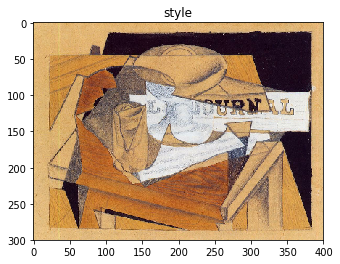

0.0 1.9794769


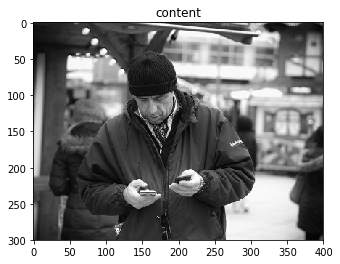

0.0 16.020409


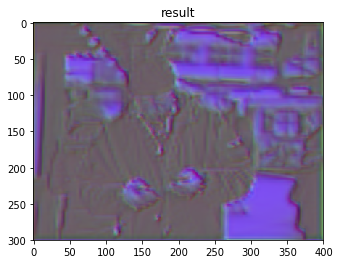

Sat May  4 11:54:35 2019	Epoch 1:	content: 20572870.000	style: 2187738.250	total: 22760608.000
1
0.0 1.9831734


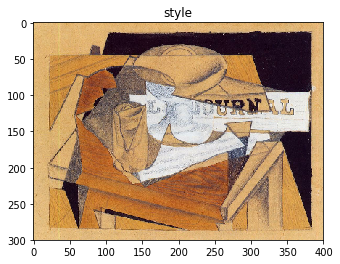

0.0 1.9794769


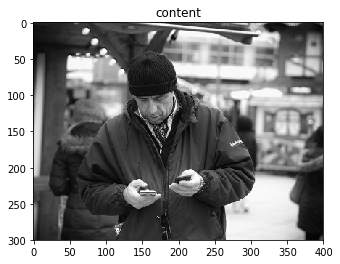

0.0 120.00509


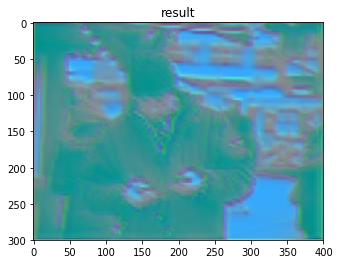

Sat May  4 11:54:48 2019	Epoch 2:	content: 884684416.000	style: 5229635584.000	total: 6114319872.000
2
0.0 1.9831734


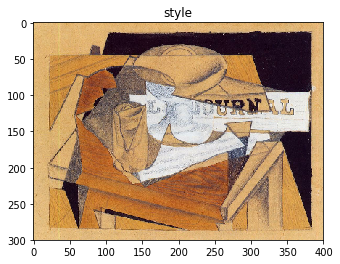

0.0 1.9794769


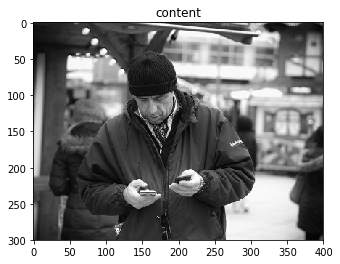

0.0 11.719401


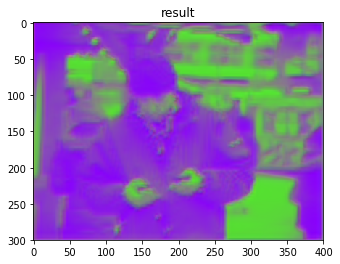

Sat May  4 11:55:01 2019	Epoch 3:	content: 26785214.000	style: 6700659.500	total: 33485874.000
3
0.0 1.9831734


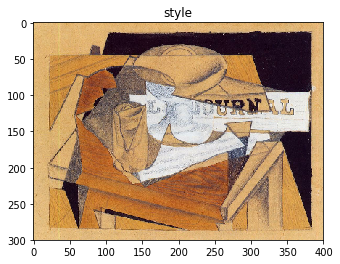

0.0 1.9794769


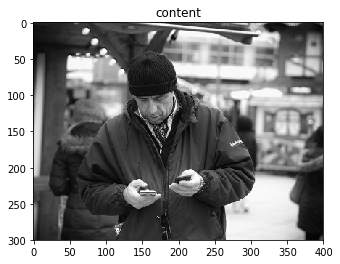

0.0 69.87118


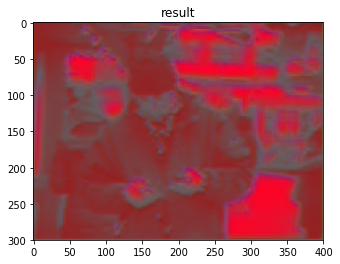

Sat May  4 11:55:15 2019	Epoch 4:	content: 465347968.000	style: 2460800000.000	total: 2926148096.000
4
0.0 1.9831734


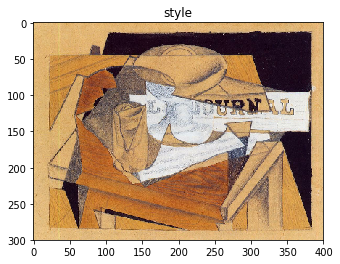

0.0 1.9794769


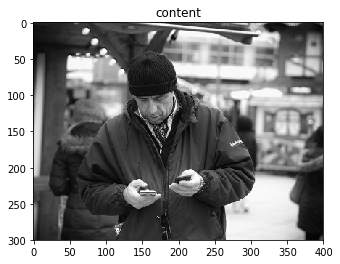

0.0 36.038414


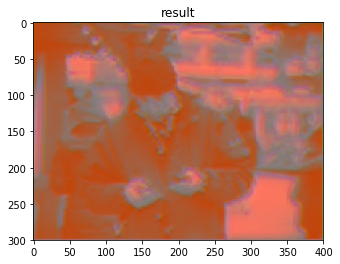

Sat May  4 11:55:31 2019	Epoch 5:	content: 105484568.000	style: 115588304.000	total: 221072864.000
5
0.0 1.9831734


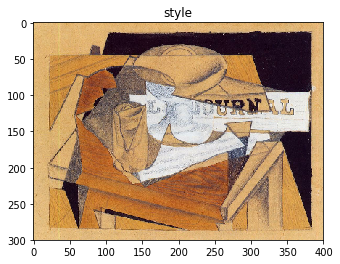

0.0 1.9794769


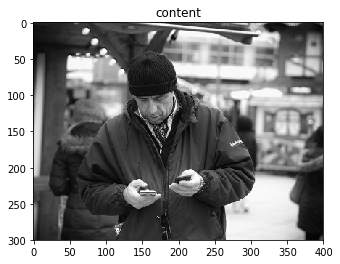

0.0 15.478708


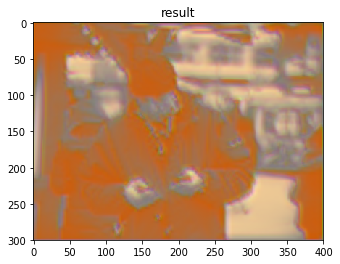

Sat May  4 11:55:45 2019	Epoch 6:	content: 18401758.000	style: 3380221.250	total: 21781980.000
6
0.0 1.9831734


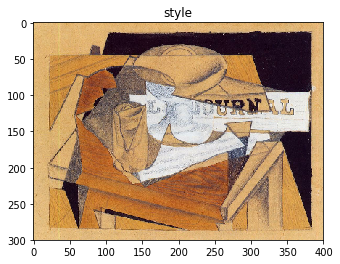

0.0 1.9794769


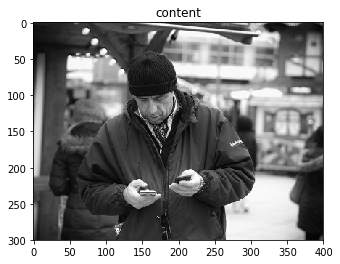

0.0 9.229588


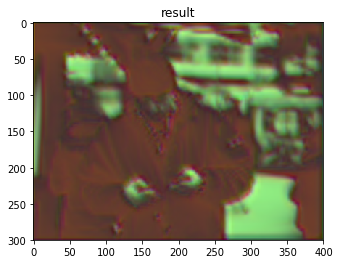

Sat May  4 11:55:59 2019	Epoch 7:	content: 7956162.500	style: 504245.156	total: 8460408.000
7
0.0 1.9831734


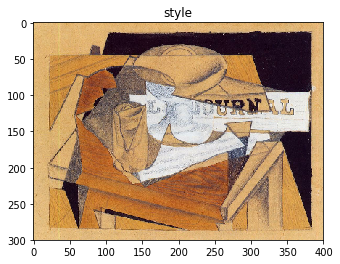

0.0 1.9794769


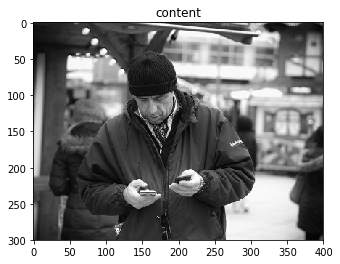

In [ ]:
style_list = load_data.get_data_paths("style")
content_list = load_data.get_data_paths("content")
train(style_list, content_list, "models")